In [1]:
from pysheds.grid import Grid
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

Text(0, 0.5, 'Latitude')

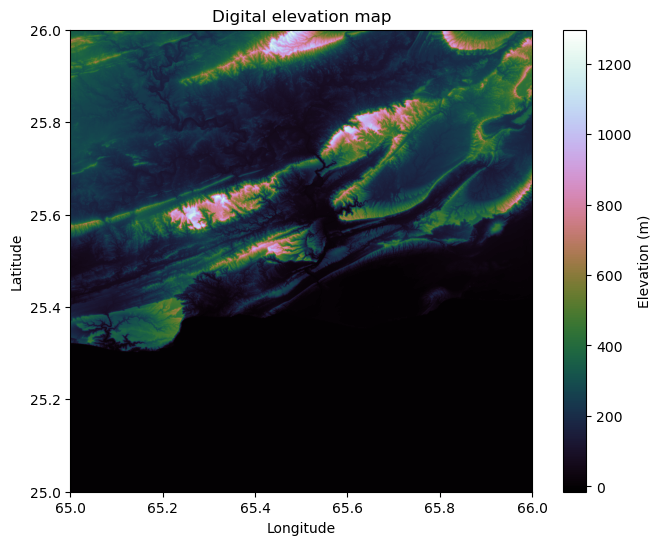

In [4]:
grid = Grid.from_raster("ALPSMLC30_N025E065_DSM.tif")
dem = grid.read_raster("ALPSMLC30_N025E065_DSM.tif")

fig, ax = plt.subplots(figsize=(8,6))
plt.imshow(dem, extent=grid.extent, cmap='cubehelix', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.title('Digital elevation map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [5]:
# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)


# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)
#plt.subplot(3, 1, 3)


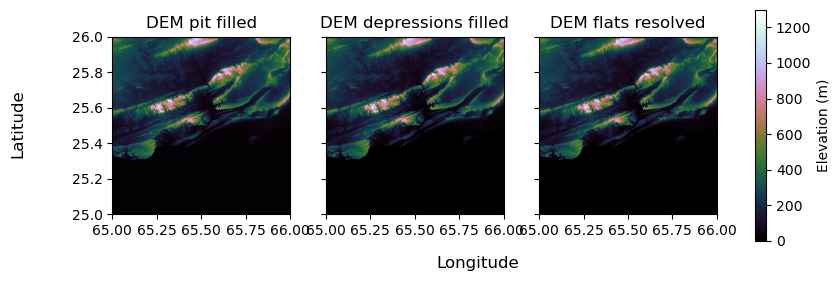

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(9.75,3), sharey=True)
ax[0].imshow(pit_filled_dem, extent=grid.extent, cmap='cubehelix', zorder=1)
ax[0].title.set_text('DEM pit filled')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
ax[1].imshow(flooded_dem, extent=grid.extent, cmap='cubehelix', zorder=1)
ax[1].title.set_text('DEM depressions filled')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
im = ax[2].imshow(inflated_dem, extent=grid.extent, cmap='cubehelix', zorder=1)
ax[2].title.set_text('DEM flats resolved')
fig.supxlabel('Longitude')
fig.supylabel('Latitude')
fig.colorbar(im ,label='Elevation (m)',ax=ax.ravel().tolist())


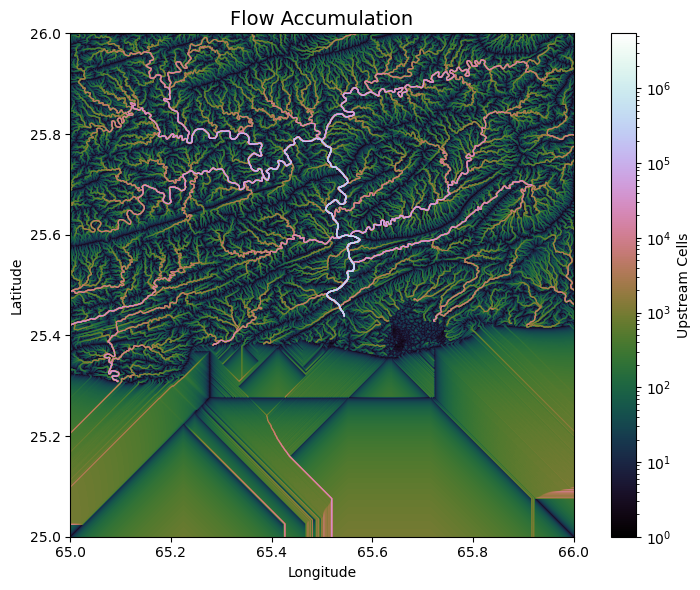

In [7]:
# Determine D8 flow directions from DEM
# ----------------------
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
    
# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

acc = grid.accumulation(fdir, dirmap=dirmap)

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

Text(0.5, 1.0, 'Delineated Catchment')

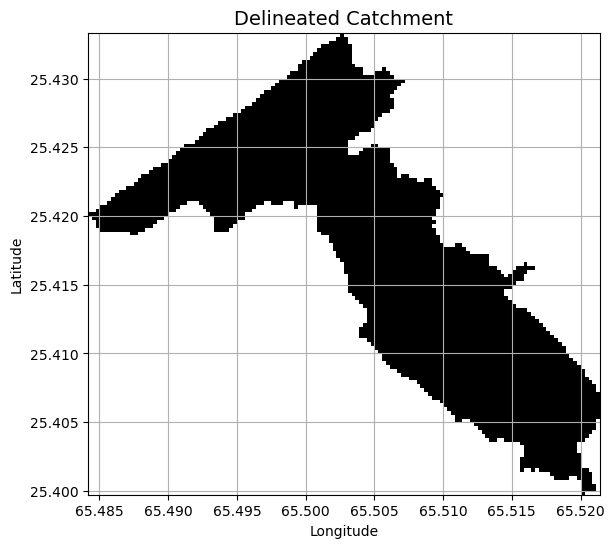

In [8]:
# Delineate a catchment
# ---------------------
# Specify pour point
x, y = 65.52,25.4

# grid.viewfinder = fdir.viewfinder

# Compute accumulation
acc = grid.accumulation(fdir)

# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))


# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, xytype='coordinate')

# Plot the result
grid.clip_to(catch)
catch_view = grid.view(catch)


# Plot the catchment
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(np.where(catch_view, catch_view, np.nan), extent=grid.extent,
               zorder=1, cmap='Greys_r')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment', size=14)

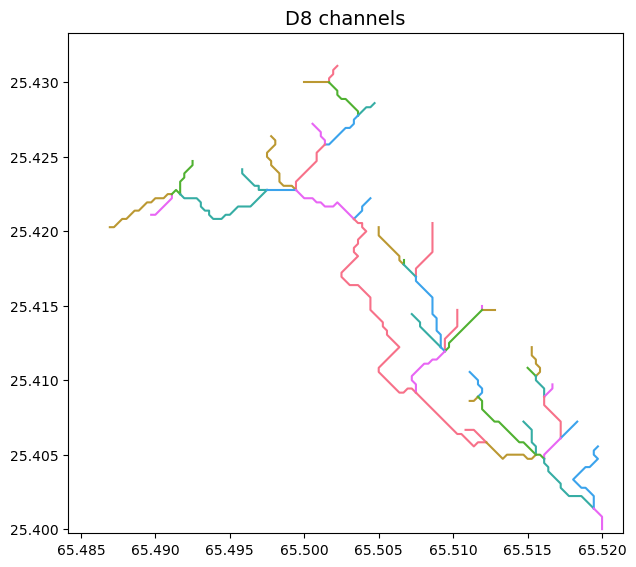

In [9]:
# Extract river network
# ---------------------
branches = grid.extract_river_network(fdir, acc > 50, dirmap=dirmap)

sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(8.5,6.5))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])
    
_ = plt.title('D8 channels', size=14)

Text(0.5, 1.0, 'Flow Distance')

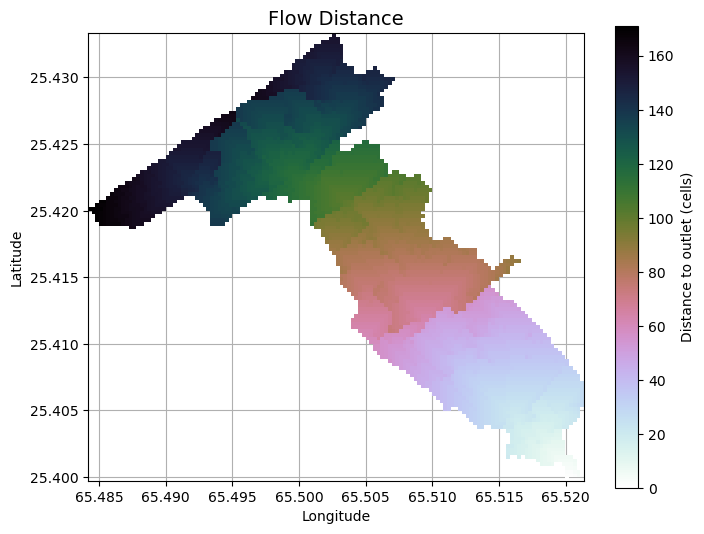

In [10]:
# Calculate distance to outlet from each cell
# -------------------------------------------
dist = grid.distance_to_outlet(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype='coordinate')

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(dist, extent=grid.extent, zorder=2,
               cmap='cubehelix_r')
plt.colorbar(im, ax=ax, label='Distance to outlet (cells)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow Distance', size=14)

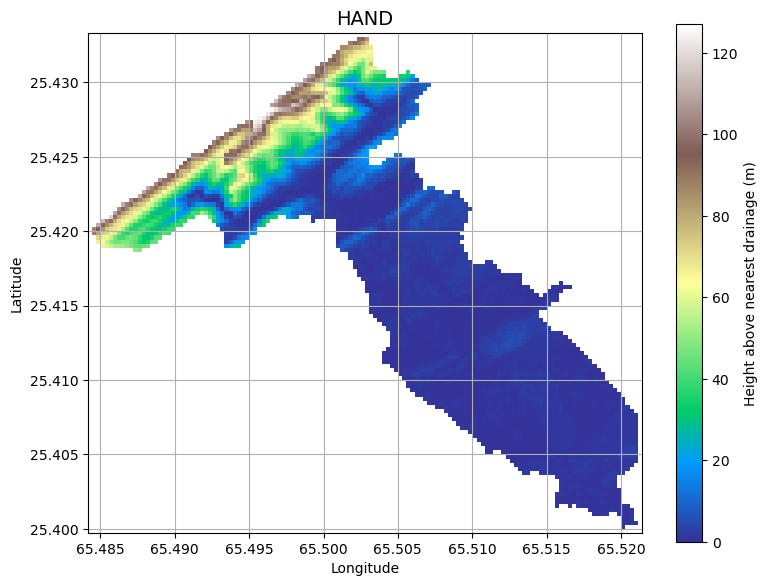

In [11]:
hand = grid.compute_hand(fdir, inflated_dem, acc > 200)
grid.clip_to(catch)
hand_view = grid.view(hand, nodata=np.nan)

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.imshow(hand_view, 
           extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Height above nearest drainage (m)')
plt.grid(zorder=0)
plt.title('HAND', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

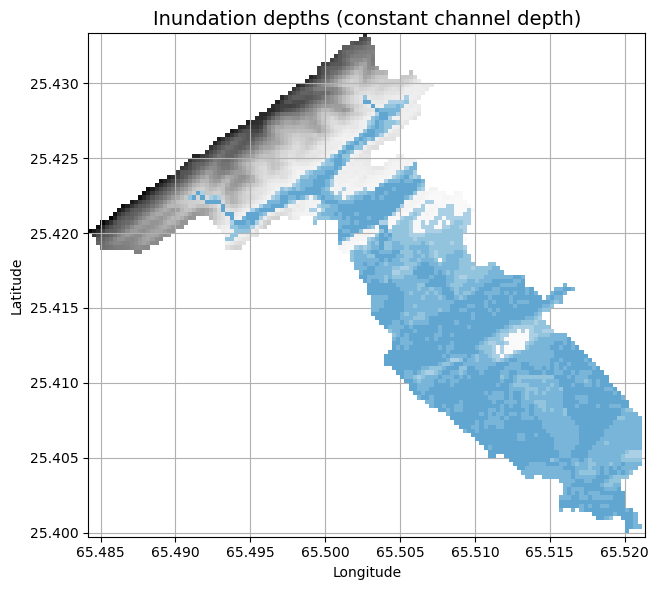

In [12]:
inundation_extent = np.where(hand_view < 3, 3 - hand_view, np.nan)

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
dem_view = grid.view(dem, nodata=np.nan)
plt.imshow(dem_view, extent=grid.extent, cmap='Greys', zorder=1)
plt.imshow(inundation_extent, extent=grid.extent,
           cmap='Blues', vmin=-5, vmax=10, zorder=2)
plt.grid(zorder=0)
plt.title('Inundation depths (constant channel depth)', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()


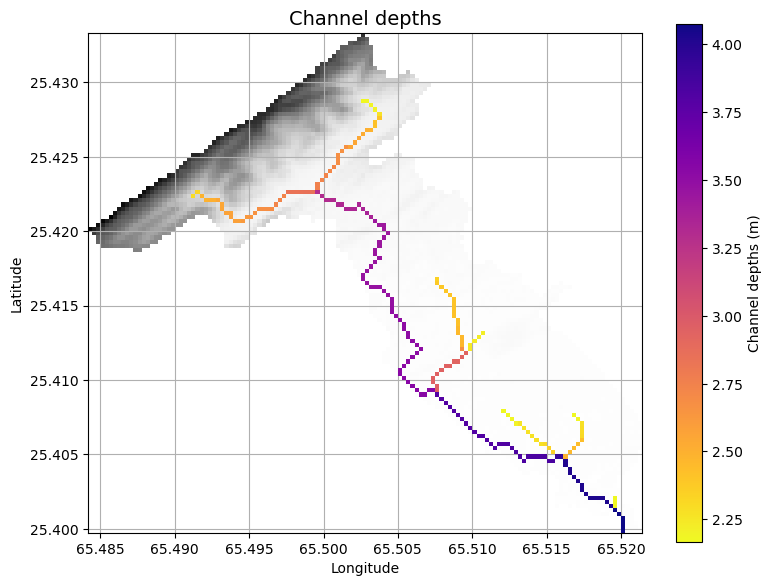

In [13]:
# Clip accumulation to current view
acc_view = grid.view(acc, nodata=np.nan)

# Create empirical channel depths based on power law 
channel_depths = np.where(acc_view > 200, 0.75 * acc_view**0.2, 0)

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
dem_view = grid.view(dem, nodata=np.nan)
plt.imshow(dem_view, extent=grid.extent, cmap='Greys', zorder=1)
plt.imshow(np.where(acc_view > 200, channel_depths, np.nan), 
           extent=grid.extent, cmap='plasma_r', zorder=2)
plt.colorbar(label='Channel depths (m)')
plt.grid(zorder=0)
plt.title('Channel depths', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

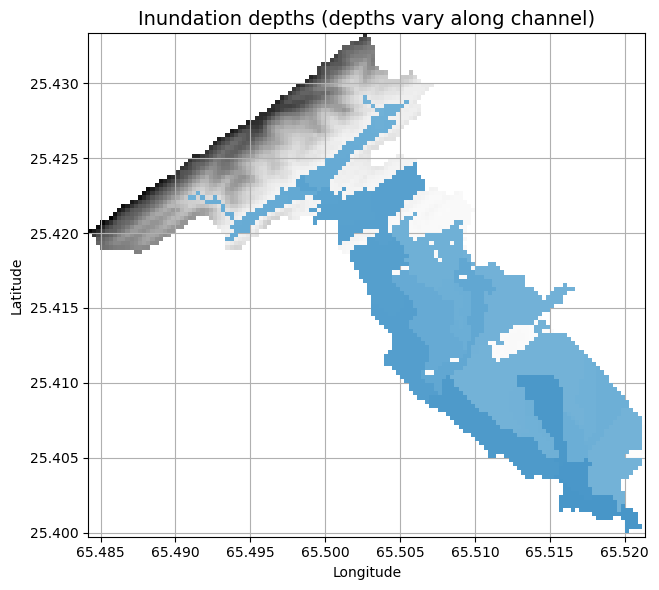

In [14]:
# Compute index of nearest channel cell for each cell
hand_idx = grid.compute_hand(fdir, dem, acc > 200, return_index=True)
hand_idx_view = grid.view(hand_idx, nodata=0)

# Compute inundation depths
inundation_depths = np.where(hand_idx_view, channel_depths.flat[hand_idx_view], np.nan)

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
dem_view = grid.view(dem, nodata=np.nan)
plt.imshow(dem_view, extent=grid.extent, cmap='Greys', zorder=1)
plt.imshow(np.where(hand_view < inundation_depths, inundation_depths, np.nan), extent=grid.extent,
           cmap='Blues', vmin=-5, vmax=10, zorder=2)
plt.grid(zorder=0)
plt.title('Inundation depths (depths vary along channel)', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

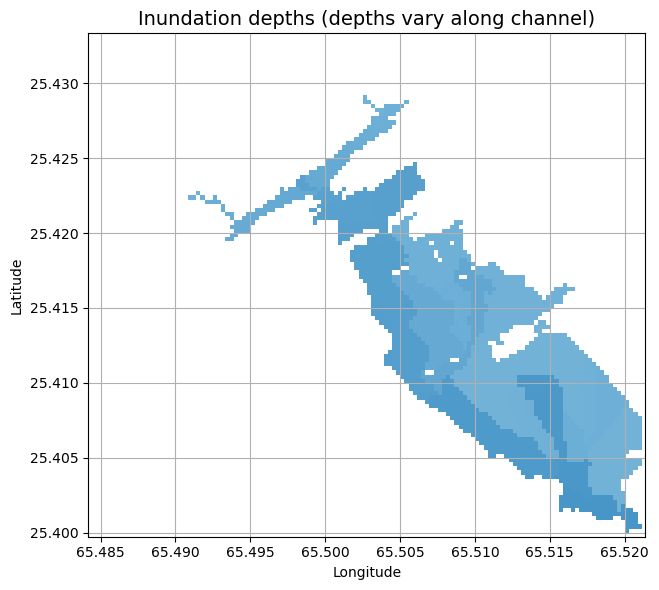

In [15]:
# Compute index of nearest channel cell for each cell
hand_idx = grid.compute_hand(fdir, dem, acc > 200, return_index=True)
hand_idx_view = grid.view(hand_idx, nodata=0)

# Compute inundation depths
inundation_depths = np.where(hand_idx_view, channel_depths.flat[hand_idx_view], np.nan)

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
dem_view = grid.view(dem, nodata=np.nan)
plt.imshow(np.where(hand_view < inundation_depths, inundation_depths, np.nan), extent=grid.extent,
           cmap='Blues', vmin=-5, vmax=10, zorder=1)
plt.grid(zorder=0)
plt.title('Inundation depths (depths vary along channel)', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

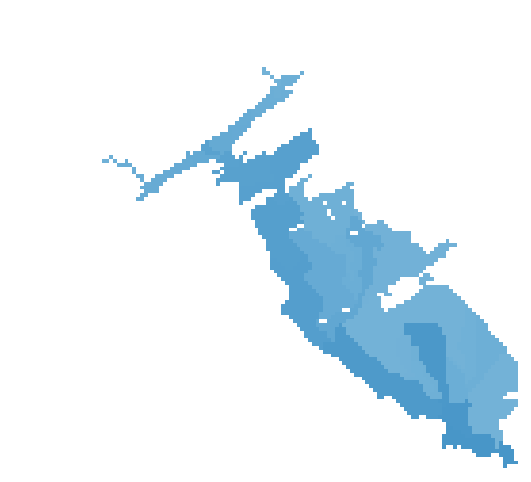

In [17]:
# Compute index of nearest channel cell for each cell
hand_idx = grid.compute_hand(fdir, dem, acc > 200, return_index=True)
hand_idx_view = grid.view(hand_idx, nodata=0)

# Compute inundation depths
inundation_depths = np.where(hand_idx_view, channel_depths.flat[hand_idx_view], np.nan)

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
dem_view = grid.view(dem, nodata=np.nan)
plt.imshow(np.where(hand_view < inundation_depths, inundation_depths, np.nan), extent=grid.extent,
           cmap='Blues', vmin=-5, vmax=10, zorder=1)
plt.axis('off')
plt.savefig('output.png', dpi=300, bbox_inches='tight', pad_inches=0)
# plt.grid(zorder=0)
# plt.title('Inundation depths (depths vary along channel)', size=14)
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.tight_layout()